# 🚕 **Predicting Taxi Fares Using Deep Learning** 📊

---

- The growth of urban transportation services, such as ride-hailing and taxi systems, has led to a significant increase in demand for accurate and transparent fare estimation. Taxi fare prediction plays a pivotal role in improving user trust, enhancing operational efficiency, and optimizing pricing strategies for service providers. 

- This project delves into the application of **deep learning regression** to predict taxi fares using a variety of influential features. By leveraging historical trip data and advanced neural network models, we aim to build a robust system that estimates fares based on parameters such as **distance traveled**, **traffic conditions**, **time of day**, and many more.

- Using the dataset sourced from [Kaggle's Taxi Price Prediction Dataset](https://www.kaggle.com/datasets/denkuznetz/taxi-price-prediction/data), this project will explore data preprocessing, feature engineering, and state-of-the-art neural network architectures to achieve high prediction accuracy. 

<div style="text-align: center;">
    <img src="https://images.indianexpress.com/2024/01/taxi-fre.jpg" alt="Image">
</div>

# Importing Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Importing Data

In [2]:
df=pd.read_csv('/kaggle/input/taxi-price-prediction/taxi_trip_pricing.csv')

# EDA - Exploratory Data Analysis 

In [3]:
df.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,Weekday,1.0,High,Clear,NaN,0.62,0.43,40.57,NaN
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,NaN,3.48,0.51,0.15,116.81,36.4698
4,NaN,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180


In [4]:
df.shape

(1000, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       950 non-null    float64
 1   Time_of_Day            950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Passenger_Count        950 non-null    float64
 4   Traffic_Conditions     950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              950 non-null    float64
 7   Per_Km_Rate            950 non-null    float64
 8   Per_Minute_Rate        950 non-null    float64
 9   Trip_Duration_Minutes  950 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB


In [6]:
df.isnull().sum()

Trip_Distance_km         50
Time_of_Day              50
Day_of_Week              50
Passenger_Count          50
Traffic_Conditions       50
Weather                  50
Base_Fare                50
Per_Km_Rate              50
Per_Minute_Rate          50
Trip_Duration_Minutes    50
Trip_Price               49
dtype: int64

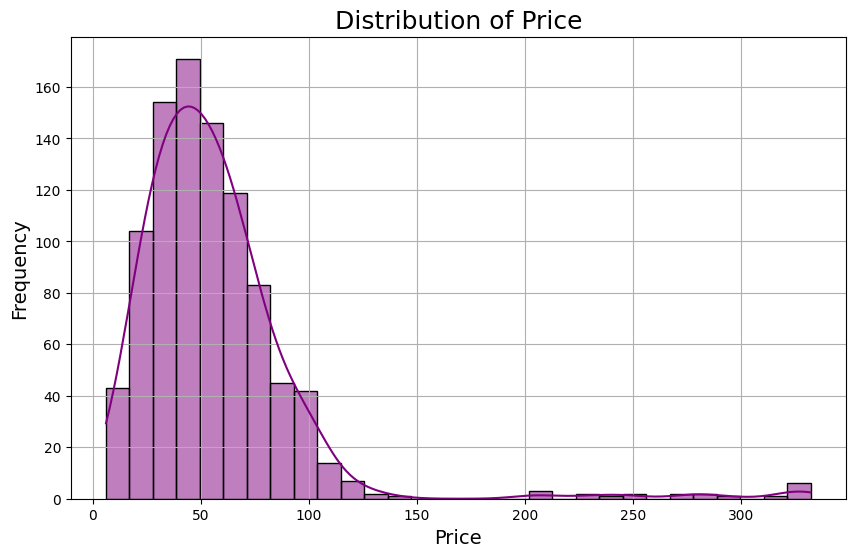

In [7]:
#distribution of price
plt.figure(figsize=(10, 6))
sns.histplot(df['Trip_Price'], bins=30, kde=True, color='purple')
plt.title('Distribution of Price', fontsize=18)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid()
plt.show()

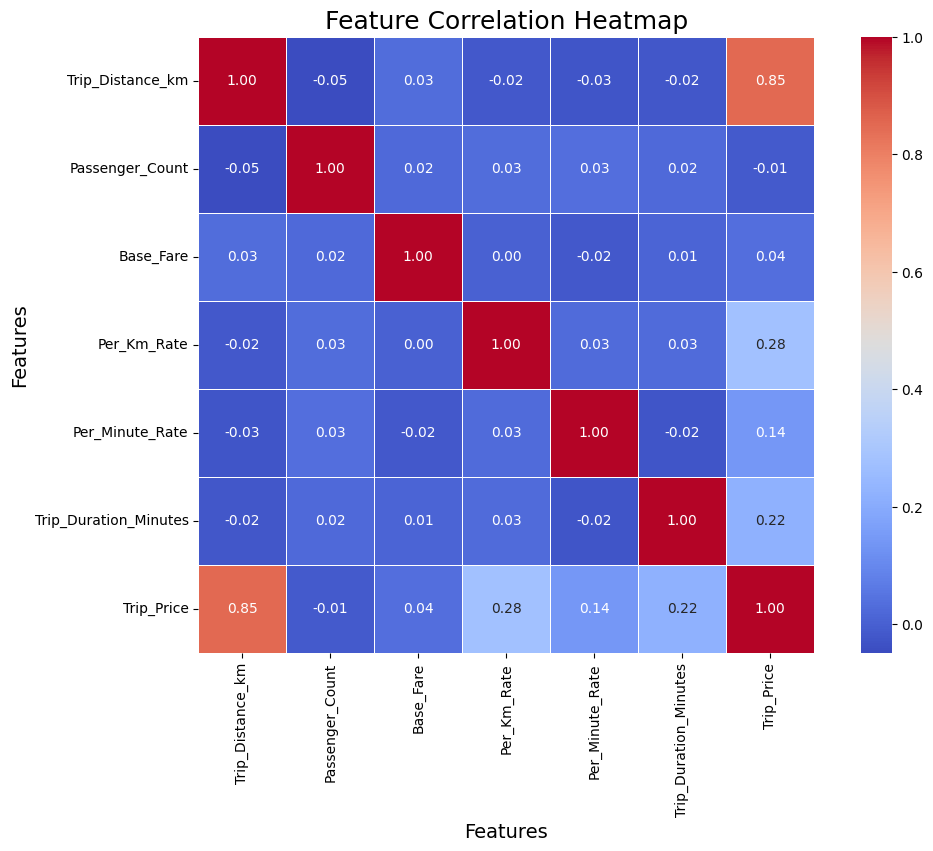

In [8]:
#correlation heatmap
numeric_df = df.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, linewidths=.5)
plt.title('Feature Correlation Heatmap', fontsize=18)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.show()

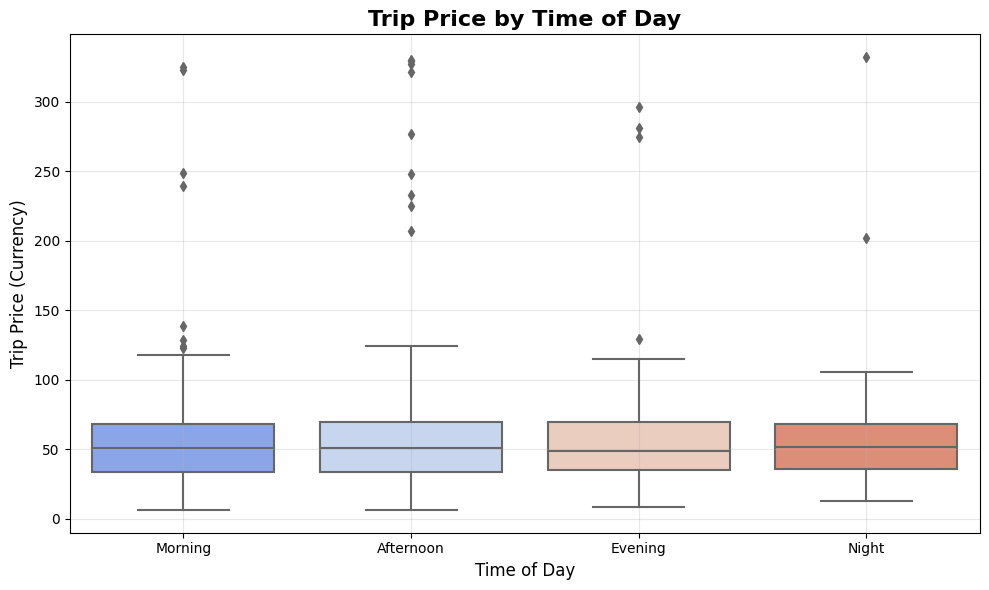

In [9]:
#time of day vs price
plt.figure(figsize=(10, 6))
sns.boxplot(x='Time_of_Day', y='Trip_Price', data=df, palette='coolwarm')
plt.title('Trip Price by Time of Day', fontsize=16, fontweight='bold')
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Trip Price (Currency)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

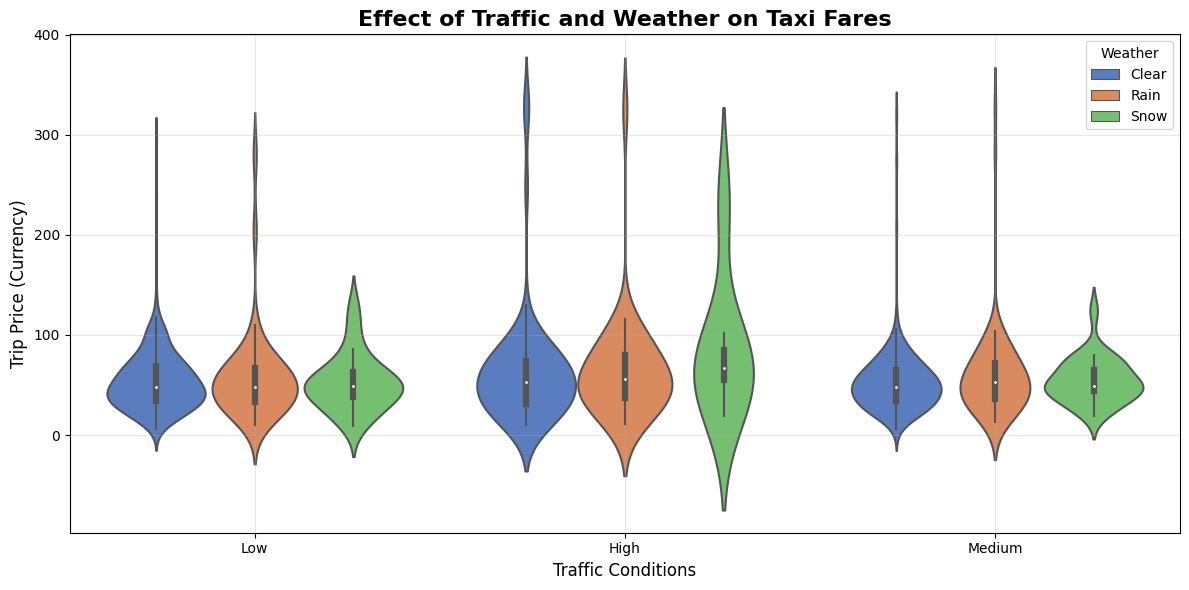

In [13]:
#traffic and weather vs price
plt.figure(figsize=(12, 6))
sns.violinplot(x='Traffic_Conditions', y='Trip_Price', hue='Weather', data=df, palette='muted')
plt.title('Effect of Traffic and Weather on Taxi Fares', fontsize=16, fontweight='bold')
plt.xlabel('Traffic Conditions', fontsize=12)
plt.ylabel('Trip Price (Currency)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Feature Engineering

In [14]:
#filling the missing values while preserving the distribution
def impute_with_sampling(df, columns):
    for col in columns:
        if df[col].isnull().sum() > 0:
            missing_count = df[col].isnull().sum()
            sampled_values = df[col].dropna().sample(n=missing_count, replace=True, random_state=42)
            sampled_values.index = df[df[col].isnull()].index  # Align indices
            df.loc[df[col].isnull(), col] = sampled_values
    return df

columns = ['Trip_Distance_km', 'Time_of_Day', 'Day_of_Week', 'Passenger_Count',
           'Traffic_Conditions', 'Weather', 'Base_Fare', 'Per_Km_Rate',
           'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price']

df = impute_with_sampling(df, columns)

In [15]:
#removing outliers using IQR
def remove_outliers_iqr(df, cols, multiplier=1.5):
    for col in cols:
        if df[col].dtype != 'object':  
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75) 
            IQR = Q3 - Q1
            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR
            # Cap values within bounds
            df[col] = np.clip(df[col], lower_bound, upper_bound)
    return df

numerical_cols = ['Trip_Distance_km', 'Base_Fare', 'Per_Km_Rate', 'Passenger_Count',
                  'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price']

df = remove_outliers_iqr(df, numerical_cols)

In [16]:
#creating synthetic features
df['Distance_Rate_Interaction'] = df['Trip_Distance_km'] * df['Per_Km_Rate']
df['Duration_Rate'] = df['Trip_Duration_Minutes'] * df['Per_Minute_Rate']

In [17]:
abs(df.corr(numeric_only=True)['Trip_Price'].sort_values(ascending=True))

Passenger_Count              0.024746
Base_Fare                    0.054950
Per_Minute_Rate              0.220167
Trip_Duration_Minutes        0.309290
Per_Km_Rate                  0.359177
Duration_Rate                0.394491
Trip_Distance_km             0.686138
Distance_Rate_Interaction    0.785304
Trip_Price                   1.000000
Name: Trip_Price, dtype: float64

In [18]:
df['Trip_Distance_km']=df['Trip_Distance_km']**2
df['Distance_Rate_Interaction']=df['Distance_Rate_Interaction']**2

# Deep Learning Modelling

In [19]:
#converting categorical variables to numeric and separating the target variable 'Trip_Price'
df = pd.get_dummies(df, drop_first=True)

x = df.drop('Trip_Price', axis=1)
y = df['Trip_Price']

In [20]:
#splitting the data into training and test sets, normalizing numerical features
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [21]:
model = Sequential([
    Dense(1024, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [22]:
history=model.fit(x_train_scaled, y_train, validation_split=0.2, epochs=300, batch_size=32,verbose=0)

In [23]:
pred = model.predict(x_test_scaled)
r2 = r2_score(y_test, pred)
rmse = mean_squared_error(y_test, pred, squared=False)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


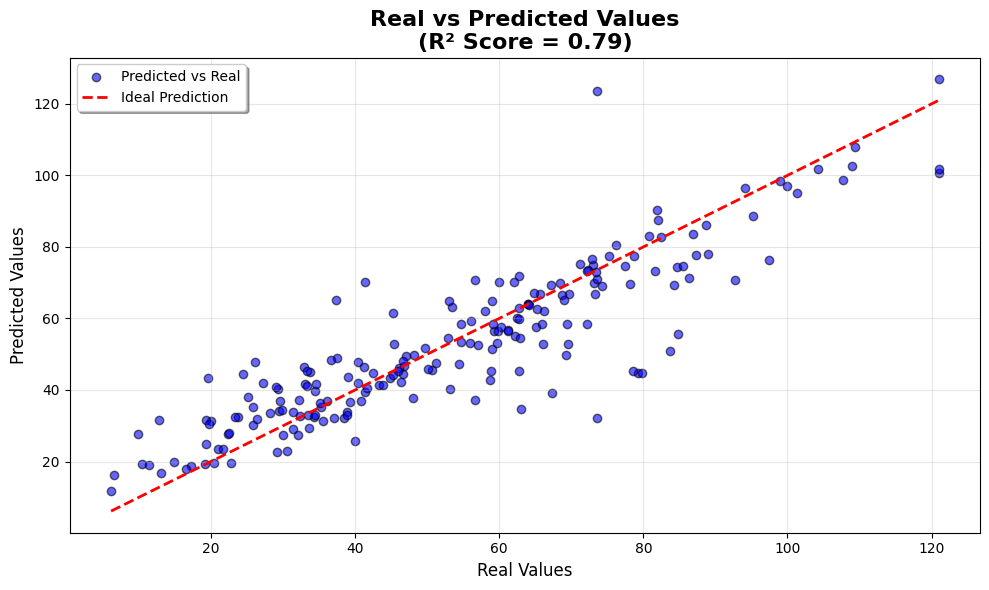

In [24]:
#real vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, pred, c='blue', alpha=0.6, edgecolor='k', label='Predicted vs Real')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Prediction')
plt.title(f"Real vs Predicted Values\n(R² Score = {r2:.2f})", fontsize=16, fontweight='bold')
plt.xlabel('Real Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.legend(loc='upper left', fontsize=10, shadow=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [25]:
rmse

11.413715916598044

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1024)                │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,033,669 (7.76 MB)

 Trainable params: 676,865 (2.58 MB)

 Non-trainable params: 3,072 (12.00 KB)

 Optimizer params: 1,353,732 (5.16 MB)

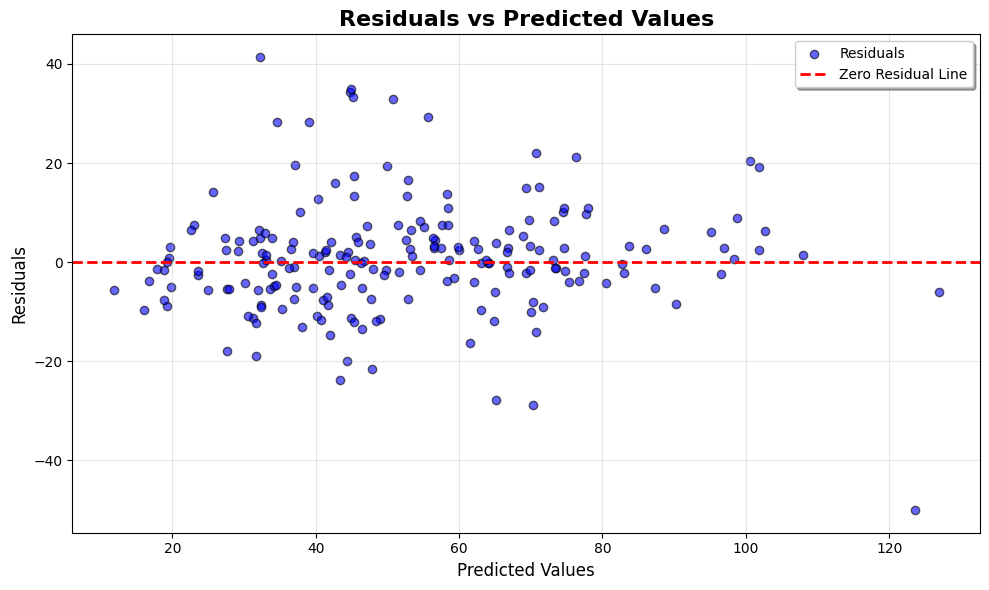

In [27]:
#residuals vs. predicted values plot
residuals = y_test - pred.flatten()
plt.figure(figsize=(10, 6))
plt.scatter(pred, residuals, color='blue', alpha=0.6, edgecolor='k', label='Residuals')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Residual Line')
plt.title("Residuals vs Predicted Values", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.legend(loc='upper right', fontsize=10, shadow=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

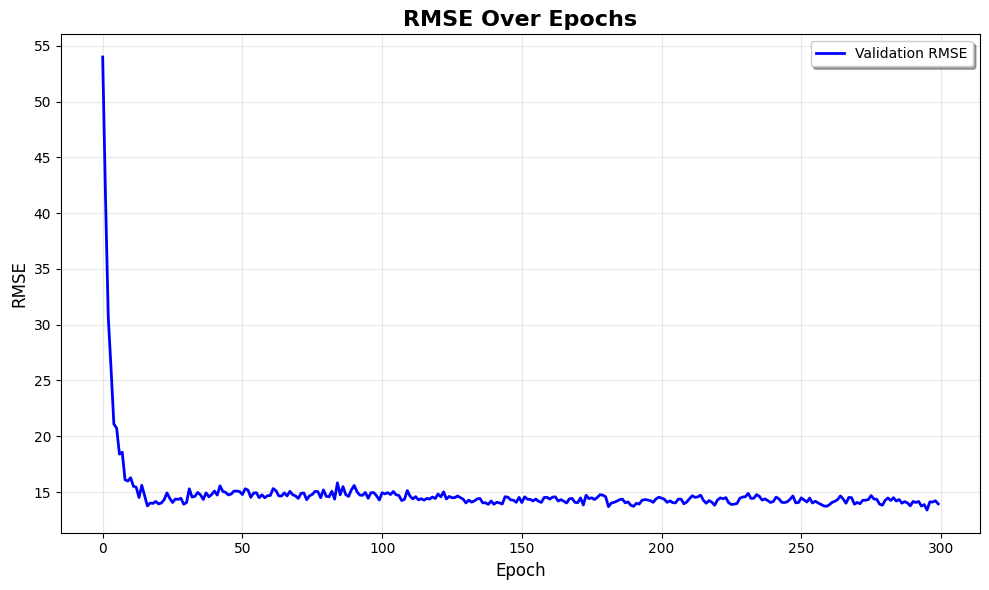

In [28]:
#RMSE over epochs
rmse_per_epoch = [val_loss ** 0.5 for val_loss in history.history['val_loss']]

plt.figure(figsize=(10, 6))
plt.plot(rmse_per_epoch, label='Validation RMSE', color='blue', lw=2)
plt.title("RMSE Over Epochs", fontsize=16, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=10, shadow=True)
plt.tight_layout()
plt.show()

## 🚖 **Results and Evaluation** 📊

---

This deep learning regression project successfully predicted taxi fares based on historical trip data, achieving commendable results:
- **R² Score**: `0.79`  
  This indicates that our model explains 80% of the variance in taxi fares, demonstrating robust predictive capability.
  
- **RMSE**: `11.41`  
  The Root Mean Squared Error reflects an average deviation of approximately `11.05 units`, showcasing the model's precision in estimating taxi prices.

These results highlight the effectiveness of the neural network architecture in capturing complex relationships between features such as **trip distance**, **traffic conditions**, **time of day**, and **weather**. While there is still room for improvement, the model exhibits excellent performance suitable for practical deployment.

---

## **Real-World Applications**

The insights and predictions from this project have significant real-world implications for the transportation sector:

- Dynamic Pricing Models: Ride-hailing platforms such as Uber and Lyft can implement the predictive model to develop transparent and dynamic fare systems, adapting prices based on factors like traffic congestion and weather conditions.

- Passenger Fare Estimates: Passengers can benefit from precise fare estimates before booking trips, fostering trust and allowing informed decisions when choosing transport services.

- Optimizing Driver Operations: Drivers can use fare predictions to identify profitable routes and adjust their schedules to maximize earnings during peak demand periods.

---